# Spatial mapping

## Preliminaries

### Import packages & data

In [1]:
import matplotlib.pyplot as plt
import warnings
import scanpy as sc
import squidpy as sq
import anndata as ad
from harmony import harmonize

/Users/mlange/mambaforge/envs/cellmapper/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/mlange/mambaforge/envs/cellmapper/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
sc.settings.set_figure_params(scanpy=True, frameon=False, fontsize=14)

Load the seqFISH data of XXX as a spatial query dataset and the scRNA-seq data of XXX as a dissociated reference dataset. Both profile mouse embryogenesis at approximately embryonic day (E) 8.5. 

In [3]:
ad_sp = sc.read("data/spatial.h5ad")
ad_sp

AnnData object with n_obs × n_vars = 51787 × 351
    obs: 'embryo', 'pos', 'z', 'embryo_pos', 'embryo_pos_z', 'Area', 'celltype_seqfish', 'sample_seqfish', 'umap_density_sample', 'modality', 'total_counts', 'n_counts', 'celltype_harmonized'
    var: 'gene_name'
    uns: 'celltype_harmonized_colors', 'celltype_seqfish_colors', 'embryo_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'X_umap_orig'
    varm: 'PCs'
    layers: 'counts', 'log_normalized'
    obsp: 'connectivities', 'distances'

In [4]:
ad_diss = sc.read("data/dissociated.h5ad")
ad_diss

AnnData object with n_obs × n_vars = 16496 × 18499
    obs: 'barcode', 'sample_rna', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype_rna', 'haem_subclust', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutDPT', 'endo_gutCluster', 'sizefactor', 'modality', 'total_counts', 'n_counts', 'celltype_harmonized'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_name'
    uns: 'celltype_harmonized_colors', 'celltype_rna_colors', 'cluster_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'sequencing.batch_colors', 'stage_colors', 'theiler_colors', 'umap'
    obsm: 'X_endo_gephi', 'X_endo_gut', 'X_haem_gephi', 'X_pca', 'X_umap', 'X_umap_orig'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

The spatial data contains all genes measured with seqFISH, the dissociated data contains all genes that passed basic filtering criteria. In both objects, `.X` corresponds to total counts normalized log1p transformed data, while raw counts are stored in `layers["counts"]`. We manually harmonized cell type annotations (stored in `.obs["celltype_harmonized"]` in either object), following ENVI (CITE). 

### Update both AnnData objects

Fix gene names

In [5]:
ad_diss.var.set_index("gene_name", inplace=True)
ad_sp.var.set_index("gene_name", inplace=True)

Put raw data into `.X`

In [6]:
ad_diss.X = ad_diss.layers["counts"].copy()
del ad_diss.layers["counts"]

ad_sp.X = ad_sp.layers["counts"].copy()
del ad_sp.layers["counts"]

Rename the `.obsm` field where spatial data is stored. 

In [7]:
ad_sp.obsm["spatial"] = ad_sp.obsm["X_spatial"].copy()
del ad_sp.obsm["X_spatial"]

Flip coordinates

In [8]:
ad_sp.obsm["spatial"][:, 1] = ad_sp.obsm["spatial"][:, 1] * -1

### Basic visualization

Let's take a closer look at these two datasets before we get started. For the seqFISH data, we can visualize harmonized cell type labels in space. 

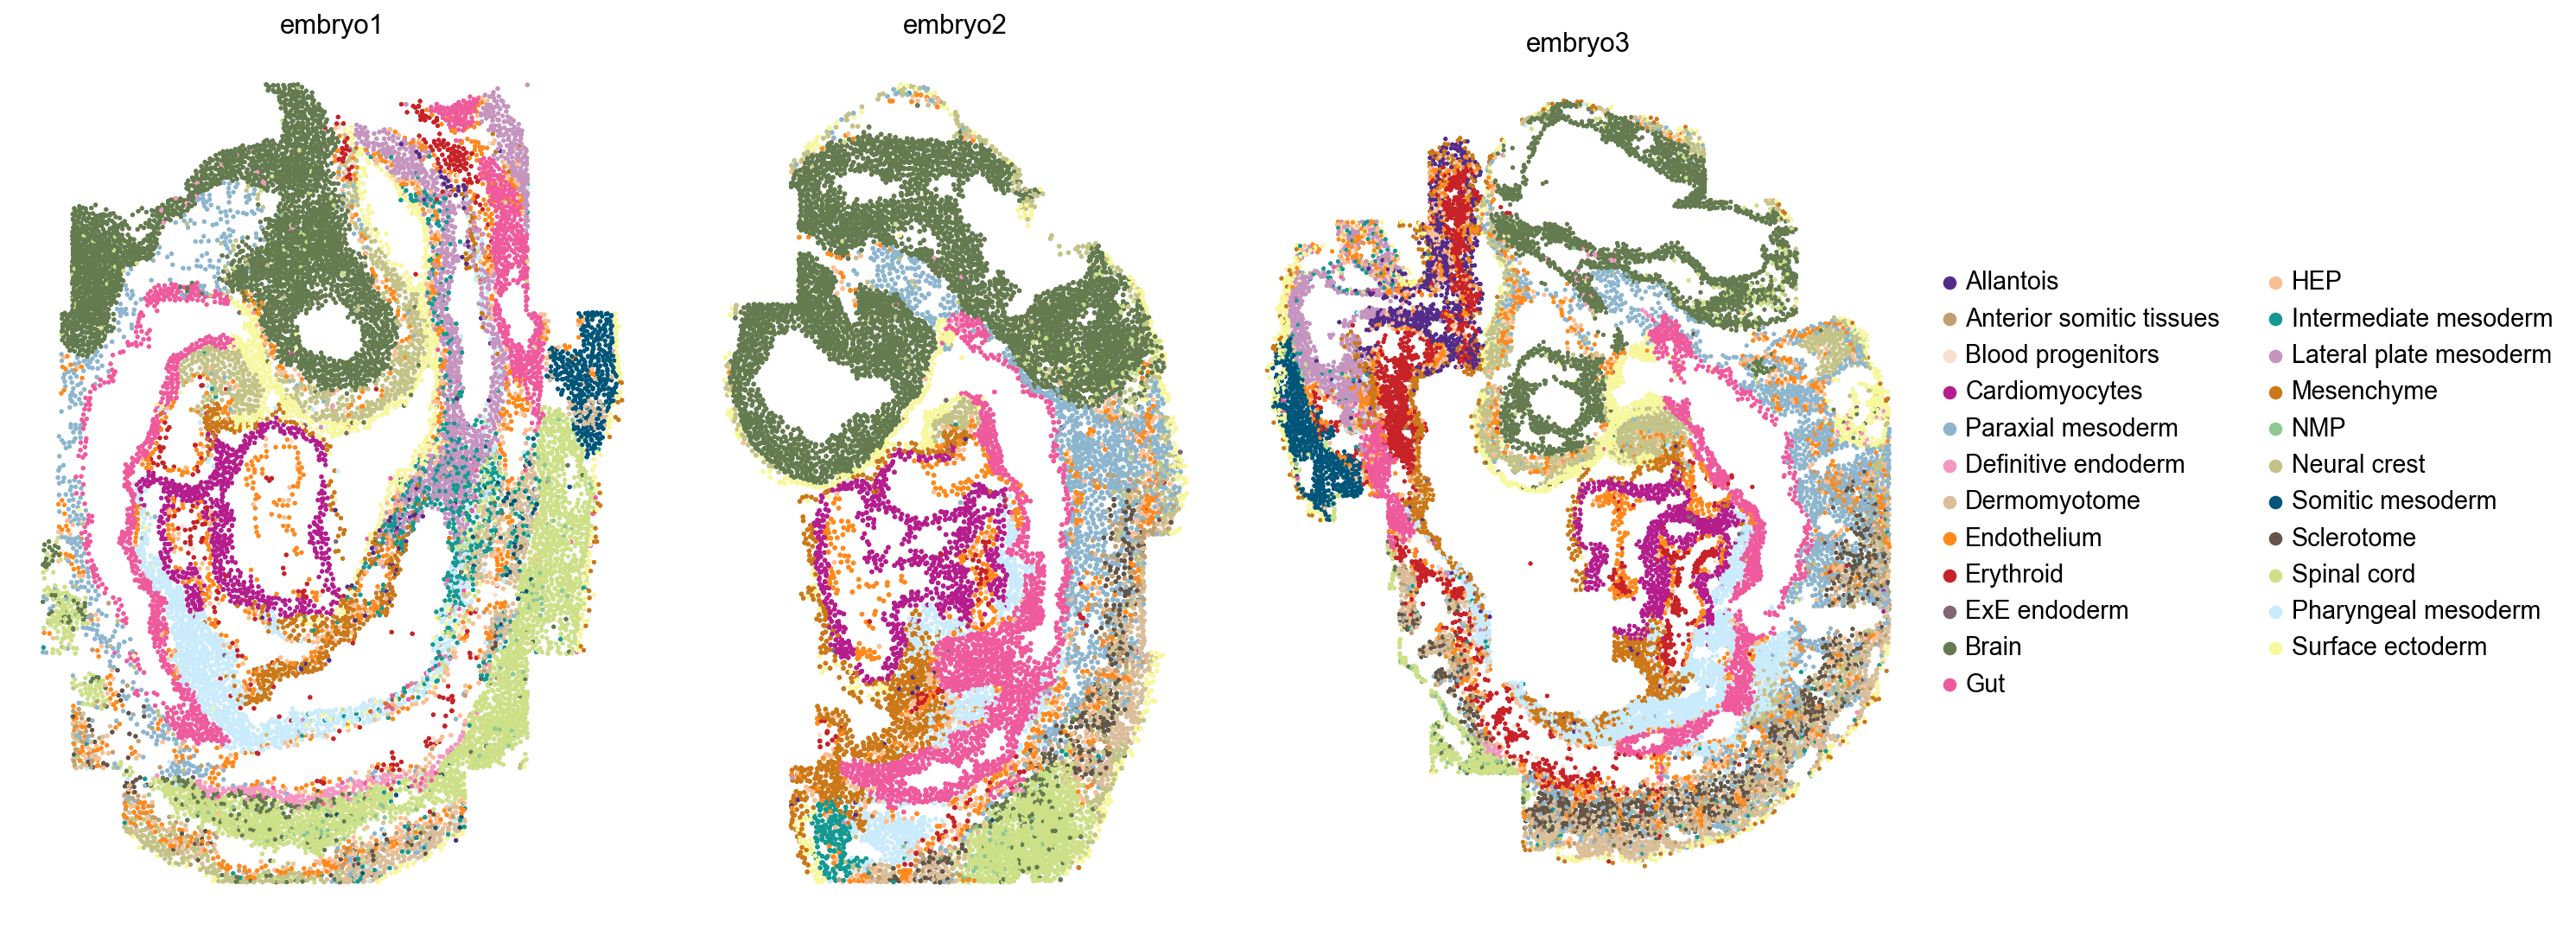

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    _, axes = plt.subplots(1, 3, figsize=(3 * 5 + 4, 7))

    for ax, cat in zip(axes, ad_sp.obs["embryo"].cat.categories, strict=True):
        obs_mask = ad_sp.obs["embryo"] == cat
        sq.pl.spatial_scatter(
            ad_sp[obs_mask],
            ax=ax,
            color="celltype_harmonized",
            title=cat,
            shape=None,
            library_id=None,
            legend_loc="right margin" if cat == "embryo3" else "none",
        )

    plt.tight_layout()

For the dissociated data, we can show a simple UMAP. 

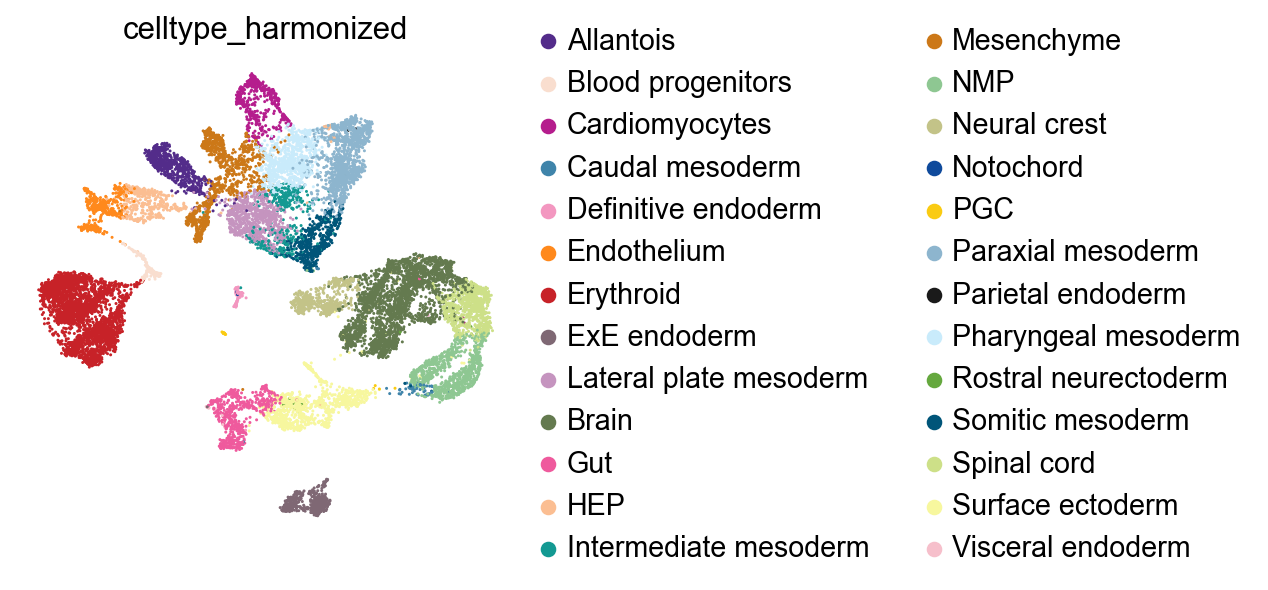

In [10]:
sc.pl.embedding(ad_diss, basis="X_umap", color="celltype_harmonized")

### Compute a joint embedding

Everything we do in `CellMapper` is based on a joint embedding between query (spatial) and reference (dissociated) data. For simplicity, we will compute such a joint embedding here with Harmony (CITE). 

In [11]:
# Harmony expects a combined AnnData object and a joint PCA
ad_combined = ad.concat([ad_sp, ad_diss], join="inner", axis=0, label="modality", keys=["sp", "diss"])
sc.pp.normalize_total(ad_combined, target_sum=1e4)
sc.pp.log1p(ad_combined)
sc.pp.pca(ad_combined)

In [12]:
# run Harmony, place the joint embedding in the obsm slot
ad_combined.obsm["X_harmony"] = harmonize(ad_combined.obsm["X_pca"], ad_combined.obs, batch_key="modality")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
Reach convergence after 7 iteration(s).


Visualize the joint PCA

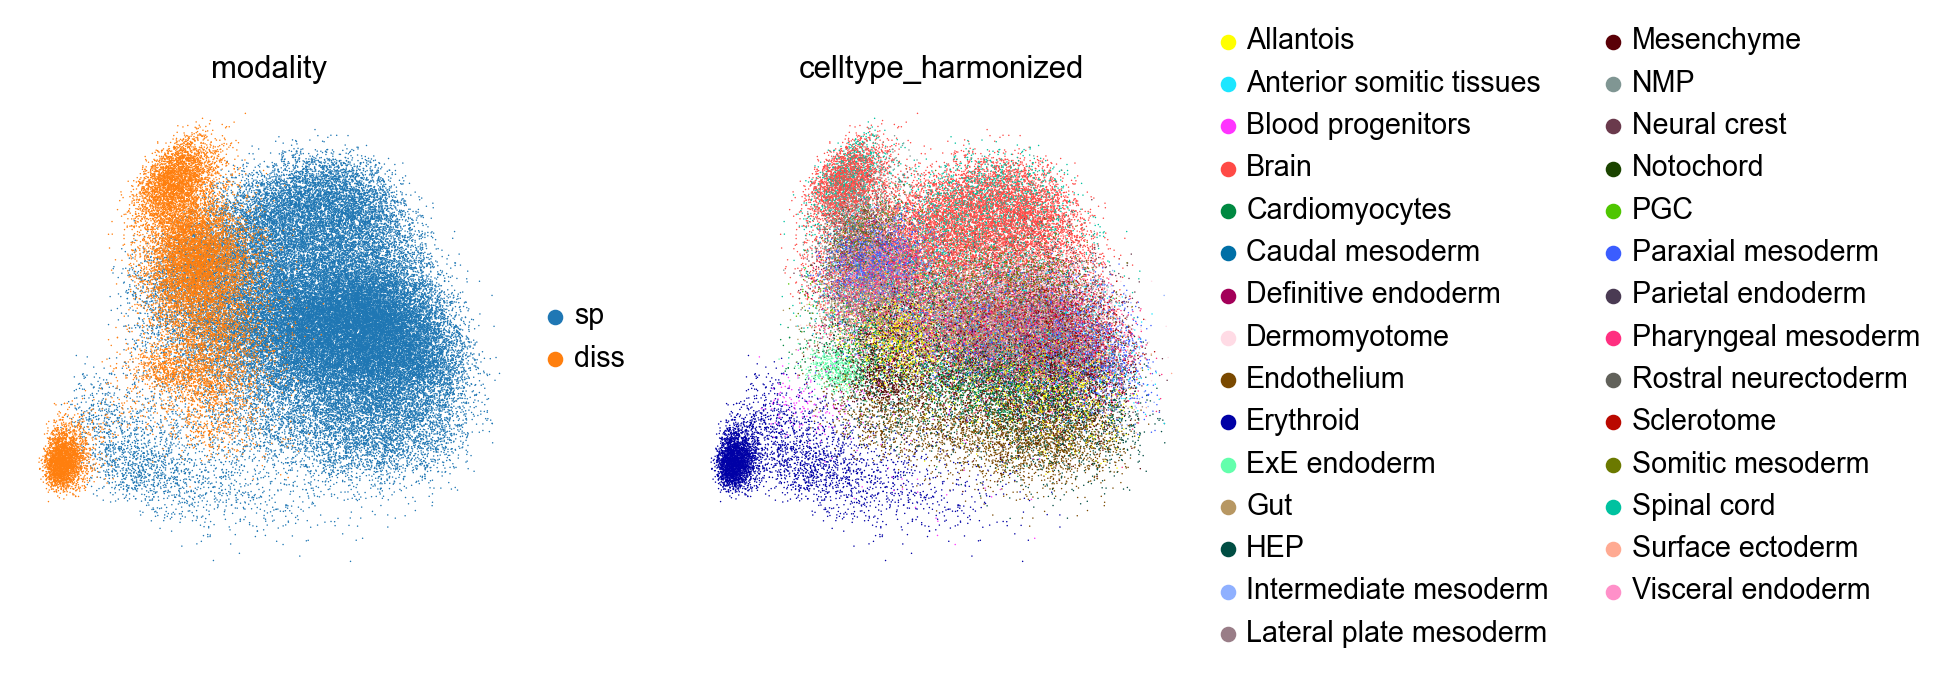

In [13]:
sc.pl.embedding(ad_combined, basis="pca", color=["modality", "celltype_harmonized"])

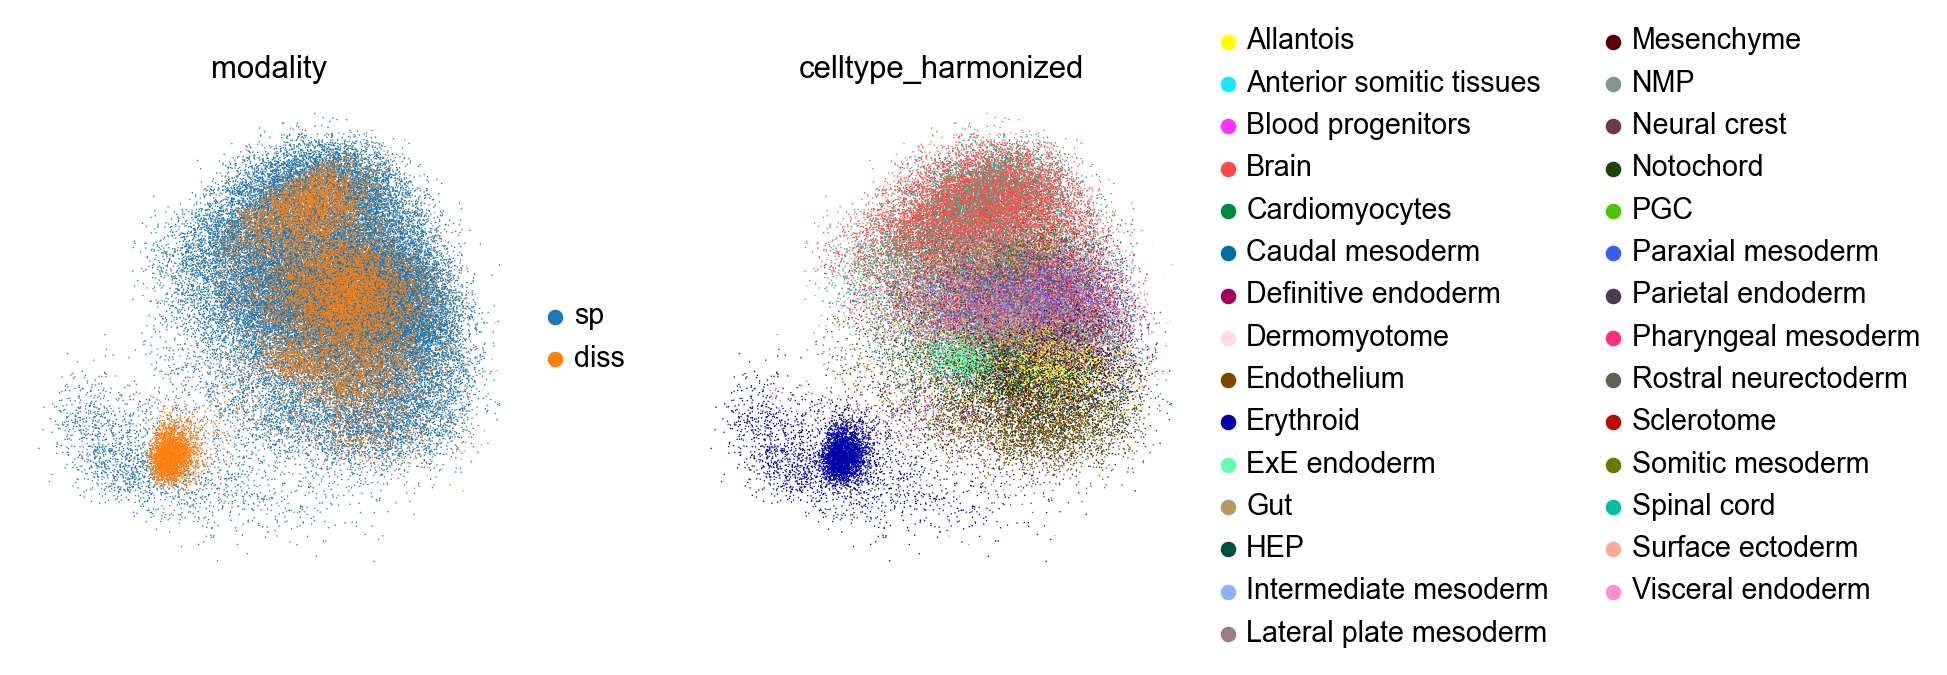

In [14]:
sc.pl.embedding(ad_combined, basis="harmony", color=["modality", "celltype_harmonized"])

In [15]:
import umap

/Users/mlange/mambaforge/envs/cellmapper/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
reducer = umap.UMAP()

In [ ]:
X_umap_pca = reducer.fit_transform(ad_combined.obsm["X_pca"])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
%prun sc.pp.neighbors(ad_combined)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/mlange/mambaforge/envs/cellmapper/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's take a quick look at this in a joint UMAP

In [ ]:
ad_combined.obsm["X_harmony"].shape

In [ ]:
sc.pp.neighbors(ad_combined, use_rep="X_harmony", transformer="sklearn", n_pcs=30)

In [ ]:
sc.tl.umap(ad_combined, key_added="X_umap_harmony")

In [ ]:
sc.pl.embedding(
    ad_combined,
    basis="X_umap_harmony",
    color=["celltype_harmonized", "modality"],
    legend_loc="right margin",
    size=10,
)

## Transfer labels

Let's pretend we don't have cell type annotations in the spatial data and we want to transfer them from the dissociated data. 